# cifar10 softmax nn

## imports

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import pickle

## data
This is CIFAR-10 dataset. Extraction directions are provided on [this](http://www.cs.toronto.edu/~kriz/cifar.html) website.

In [6]:
def unpickle(file):
    with open(file, "rb") as f:
        data_map = pickle.load(f, encoding="bytes")
    return data_map

In [7]:
data_batch_1 = unpickle("../my_datasets/cifar-10-batches-py/data_batch_1")

In [24]:
#datapoint
data_batch_1[b"data"][0].shape

(3072,)

In [17]:
#label
data_batch_1[b"labels"][0]

6

In [18]:
img_dim = [32, 32]

The images currently aren't in a render-ready form. From the website provided above: "The next 3072 bytes are the values of the pixels of the image. The first 1024 bytes are the red channel values, the next 1024 the green, and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image."

[Matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) will required an m\*n\*3, where m is the horizontal dimension, n is the vertical dimension, and 3 is the number of color channels.

In [20]:
plt.imshow(data_batch_1[b"data"][0].reshape(img_dim))

ValueError: cannot reshape array of size 3072 into shape (32,32)

We'll define a function below to get the image ready.

In [41]:
int(len(data_batch_1[b"data"][0]) / 3)

1024

In [60]:
def mutate_img(arr, flatten=False):
    #color channels
    color_channels = 3
    #offset between r->g, g->b (constant, w*h)
    color_offset = int(len(arr) / color_channels)
    #image pixel 0 (r0, g0, b0) is at indices flat_img[0:3]
    #image pixel i (ri, gi, bi) is at indices flat_image[i*3:i*3 + 3]
    flat_img = []
    for i in range(color_offset):
        for j in range(color_channels):
            flat_img.append(arr[i + j*color_offset])
    
    #reshape if necessary
    dim = int(color_offset ** .5)
    result = np.asarray(flat_img)
    if not flatten:
        result = result.reshape([dim, dim, color_channels])
    #return image
    return result

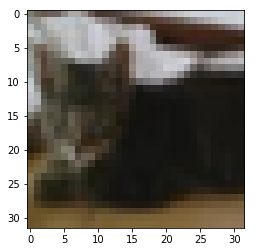

In [65]:
for i in range(10):
    plt.imshow(mutate_img(data_batch_1[b"data"][i]))

We'll create a small helper function to display multiple images.

In [ ]:
def show_multiple_images(rows=8, cols=8):
    idxs = []
    fig = plt.figure(figsize=(10, 10))
    for i in range(1, rows*cols + 1):
        #get image
        img_ls = data_batch_1[b"data"]
        idxs.append(np.random.randint(low=0, high=len(img_ls)))
        img = mutate_img(img_ls[idxs][-1])
        
        #plot
        fig.add_subplot(rows, cols, i)
        